In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import shap
plt.style.use('seaborn-v0_8-whitegrid')

In [277]:
# Load your dataset
df = pd.read_csv('/content/Database of Carbon-based Supercapacitors.csv')
df.head(10)

,DOI,Materials-1,Materials-2,Materials-note,Electrolyte,Voltage window (V),Specific surface area (m2/g),Capacitance (F/g),Pore volume (cm3/g),Pore size (nm),Micropore volume (cm3/g),SSA of micropores (m2/g),Id/Ig,N (at. %),O (at. %),B (at. %),S (at. %),F (at. %),P (at. %)
0,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,630.0,80.0,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1000.0,125.0,NaN,1.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1500.0,175.0,NaN,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1400.0,160.0,NaN,2.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,850.0,95.0,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1800.0,138.0,NaN,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1700.0,143.0,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10.1149/1.1921134,CDC,NaN,NaN,h2so4,0.25,1100.0,120.0,NaN,1.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10.1002/smll.200500327,MWCNT,NaN,NaN,teabf4,3.50,20.0,35.0,0.11,NaN,0.02,NaN,1.02,NaN,NaN,NaN,NaN,NaN,NaN
9,10.1002/smll.200500327,MWCNT,NaN,NaN,teabf4,3.50,73.0,NaN,0.18,NaN,0.07,NaN,0.88,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
drop = ['DOI' , 'Materials-2' , 'Materials-note']
df = df.drop(columns=drop)
df.head()

,Materials-1,Electrolyte,Voltage window (V),Specific surface area (m2/g),Capacitance (F/g),Pore volume (cm3/g),Pore size (nm),Micropore volume (cm3/g),SSA of micropores (m2/g),Id/Ig,N (at. %),O (at. %),B (at. %),S (at. %),F (at. %),P (at. %)
0,CDC,h2so4,0.25,630.0,80.0,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDC,h2so4,0.25,1000.0,125.0,NaN,1.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDC,h2so4,0.25,1500.0,175.0,NaN,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CDC,h2so4,0.25,1400.0,160.0,NaN,2.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDC,h2so4,0.25,850.0,95.0,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
df.isna().sum()

,0
Materials-1,9
Electrolyte,13
Voltage window (V),16
Specific surface area (m2/g),36
Capacitance (F/g),125
Pore volume (cm3/g),147
Pore size (nm),258
Micropore volume (cm3/g),364
SSA of micropores (m2/g),500
Id/Ig,401


In [280]:
df.shape

(681, 16)

In [281]:
# 1. Handle Missing Values
# In materials science, missing doping values (e.g., B at. %) usually mean 0% doping.
doping_cols = ['N (at. %)', 'O (at. %)', 'B (at. %)', 'S (at. %)', 'F (at. %)', 'P (at. %)']
df[doping_cols] = df[doping_cols].fillna(0)

df = df.dropna(subset=['Capacitance (F/g)'])


In [282]:
df["Pore volume (cm3/g)"] = df["Pore volume (cm3/g)"].fillna(
    df["Pore volume (cm3/g)"].median()
)
df["Pore size (nm)"] = df["Pore size (nm)"].fillna(
    df["Pore size (nm)"].median()
)
df["Micropore volume (cm3/g)"] = df["Micropore volume (cm3/g)"].fillna(
    df["Micropore volume (cm3/g)"].median()
)
df["Specific surface area (m2/g)"] = df["Specific surface area (m2/g)"].fillna(df["Specific surface area (m2/g)"].median())
df["micropore_ssa_missing"] = df["SSA of micropores (m2/g)"].isna().astype(int)
df["Id/Ig_missing"] = df['Id/Ig '].isna().astype(int)
df = df.drop("Id/Ig ", axis=1)

In [283]:
col = ["SSA of micropores (m2/g)", "Micropore volume (cm3/g)"]
df = df.drop(columns=["SSA of micropores (m2/g)"])

In [284]:
enc = ['Materials-1', 'Electrolyte', 'Voltage window (V)']

for col in enc:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-3481967995.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [285]:
df.isna().sum()

,0
Materials-1,0
Electrolyte,0
Voltage window (V),0
Specific surface area (m2/g),0
Capacitance (F/g),0
Pore volume (cm3/g),0
Pore size (nm),0
Micropore volume (cm3/g),0
N (at. %),0
O (at. %),0


In [286]:
le = LabelEncoder()
encode = ['Materials-1', 'Electrolyte']

for col in encode:
    df[col] = le.fit_transform(df[col])


In [287]:
df.describe()

,Materials-1,Electrolyte,Voltage window (V),Specific surface area (m2/g),Capacitance (F/g),Pore volume (cm3/g),Pore size (nm),Micropore volume (cm3/g),N (at. %),O (at. %),B (at. %),S (at. %),F (at. %),P (at. %),micropore_ssa_missing,Id/Ig_missing
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,22.084532,16.217626,1.297122,1217.241437,188.807554,1.039066,2.404442,0.392851,1.334167,4.346478,0.103975,0.068147,0.017806,0.010558,0.746403,0.575540
std,12.482566,4.439923,0.780015,847.548360,104.053038,0.750209,2.324838,0.217476,2.879602,6.413577,0.750197,0.322642,0.270047,0.107801,0.435461,0.494706
min,0.000000,0.000000,0.250000,1.400000,1.900000,0.001800,0.211000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,13.000000,1.000000,549.945000,120.000000,0.610000,1.200000,0.367500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,17.000000,1.000000,1080.000000,177.000000,0.860000,2.000000,0.367500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,34.000000,17.000000,1.000000,1644.250000,248.250000,1.280000,2.537500,0.367500,1.155000,7.100000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,37.000000,29.000000,4.000000,4073.000000,587.000000,5.910000,27.200000,1.980000,19.800000,37.500000,9.600000,3.100000,5.600000,1.600000,1.000000,1.000000


<Axes: >

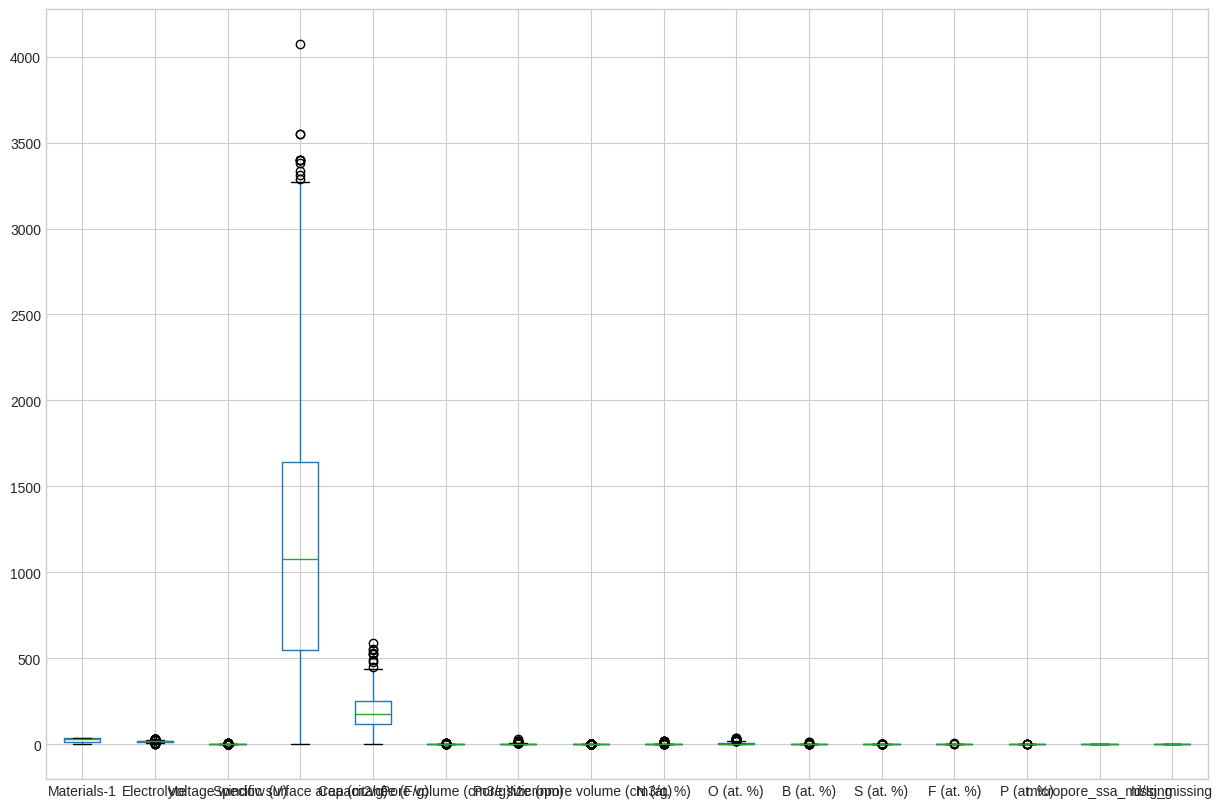

In [288]:
df.boxplot(figsize=(15, 10))

In [289]:
from sklearn.preprocessing import RobustScaler

scale_cols = [
    'Voltage window (V)',
    'Specific surface area (m2/g)',
    'Capacitance (F/g)',
    'Pore size (nm)',
    'Pore volume (cm3/g)',
    'Micropore volume (cm3/g)',
    'N (at. %)',
    'O (at. %)',
    'B (at. %)',
    'S (at. %)',
    'F (at. %)',
    'P (at. %)',

]

scaler = RobustScaler()
scaler.fit(df[scale_cols])
df[scale_cols] = scaler.transform(df[scale_cols])

<Axes: >

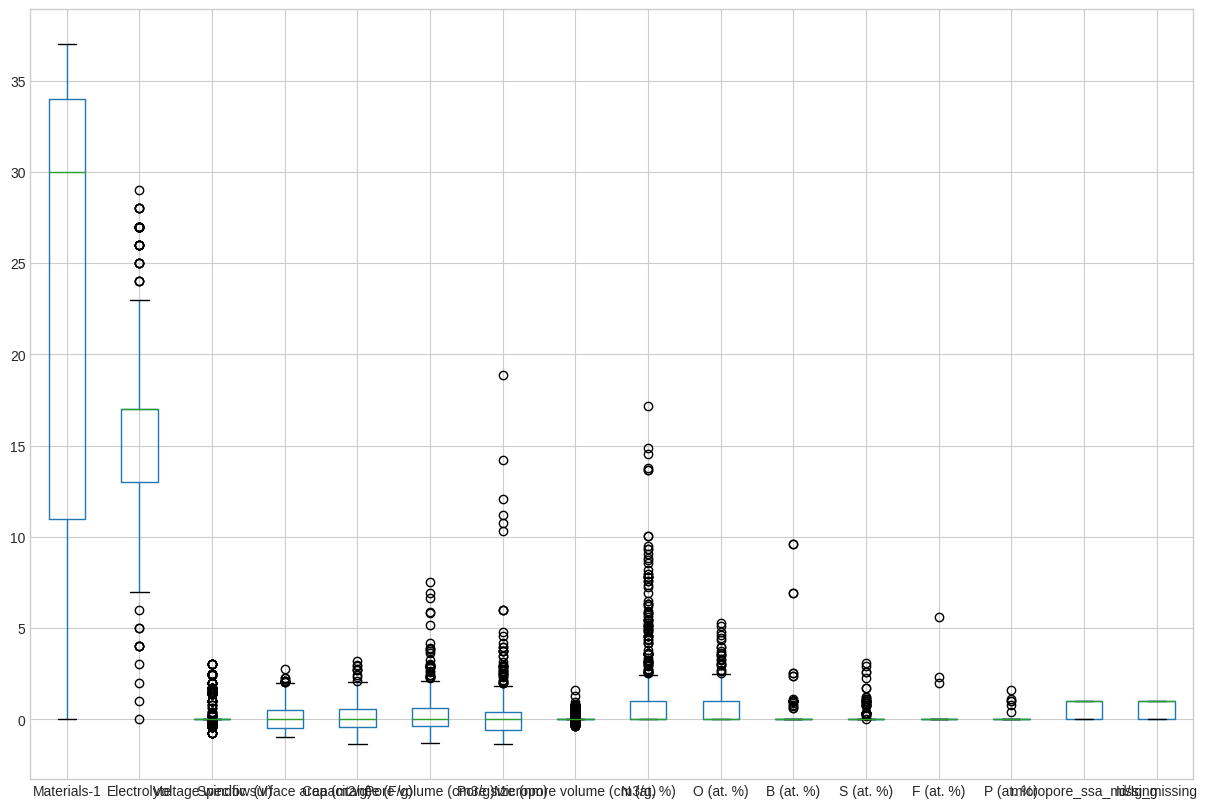

In [290]:
df.boxplot(figsize=(15, 10))

In [291]:

num_cols = [
    'Voltage window (V)',
    'Specific surface area (m2/g)',
    'Capacitance (F/g)',
    'Pore volume (cm3/g)',
    'Pore size (nm)',
    'Micropore volume (cm3/g)',
    'N (at. %)',
    'O (at. %)',
    'B (at. %)',
    'S (at. %)',
    'F (at. %)',
    'P (at. %)'
]

# Compute IQR
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Boolean mask for outliers
outlier_mask = ((df[num_cols] < (Q1 - 1.5 * IQR)) |
                (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

print("Number of rows with outliers:", outlier_mask.sum())


Number of rows with outliers: 467


In [292]:
for col in num_cols:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    df[col] = df[col].clip(lower, upper)

<Axes: >

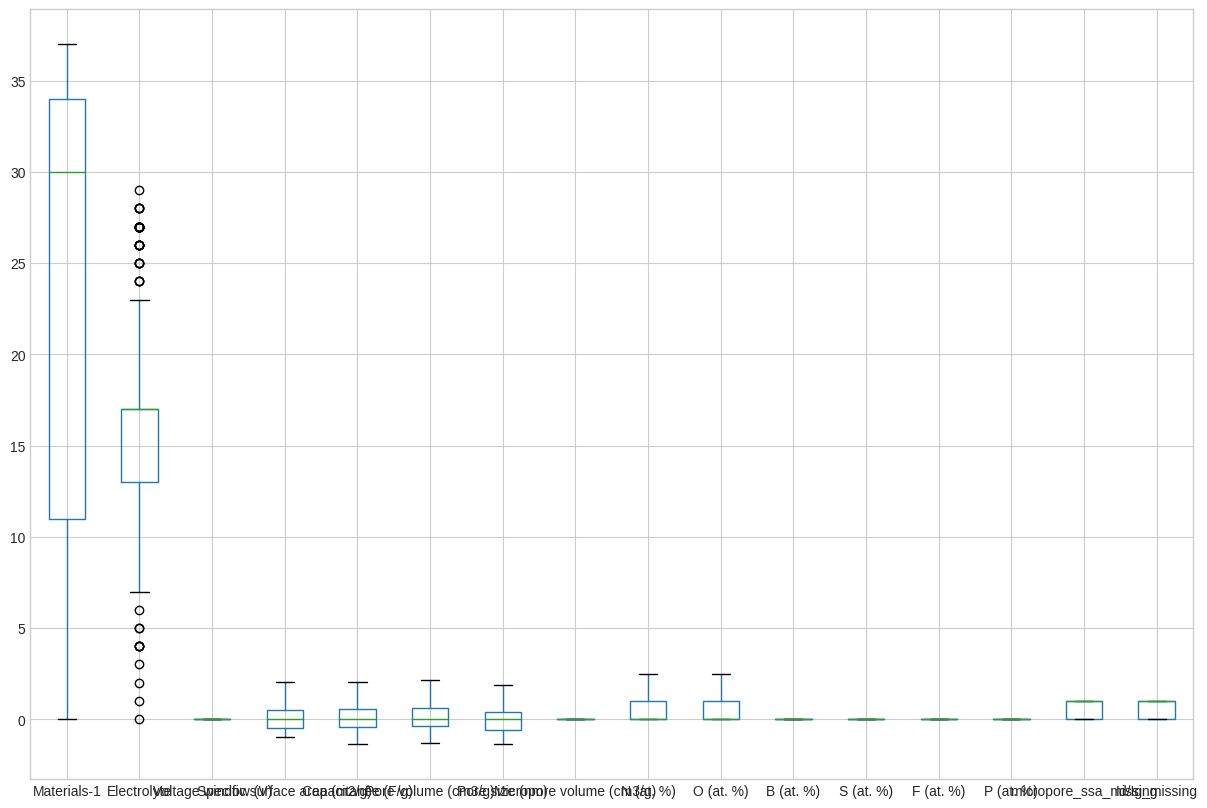

In [300]:
df.boxplot(figsize=(15, 10))

In [293]:
df.head()

,Materials-1,Electrolyte,Voltage window (V),Specific surface area (m2/g),Capacitance (F/g),Pore volume (cm3/g),Pore size (nm),Micropore volume (cm3/g),N (at. %),O (at. %),B (at. %),S (at. %),F (at. %),P (at. %),micropore_ssa_missing,Id/Ig_missing
0,7,13,0.0,-0.411220,-0.756335,0.0,-0.373832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,7,13,0.0,-0.073106,-0.405458,0.0,-0.186916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,7,13,0.0,0.383805,-0.015595,0.0,0.373832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,7,13,0.0,0.292423,-0.132554,0.0,0.672897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,7,13,0.0,-0.210179,-0.639376,0.0,-0.560748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [304]:
df.corr()

,Materials-1,Electrolyte,Voltage window (V),Specific surface area (m2/g),Capacitance (F/g),Pore volume (cm3/g),Pore size (nm),Micropore volume (cm3/g),N (at. %),O (at. %),B (at. %),S (at. %),F (at. %),P (at. %),micropore_ssa_missing,Id/Ig_missing
Materials-1,1.000000,0.047101,NaN,-0.084659,-0.068894,-0.000545,0.105573,NaN,-0.199744,-0.082761,NaN,NaN,NaN,NaN,0.020525,0.047254
Electrolyte,0.047101,1.000000,NaN,-0.039744,-0.105304,-0.029166,-0.020590,NaN,0.009250,0.023038,NaN,NaN,NaN,NaN,0.113402,-0.084198
Voltage window (V),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Specific surface area (m2/g),-0.084659,-0.039744,NaN,1.000000,0.331773,0.540553,-0.149523,NaN,0.007668,0.054960,NaN,NaN,NaN,NaN,-0.072740,-0.019330
Capacitance (F/g),-0.068894,-0.105304,NaN,0.331773,1.000000,0.118333,0.014596,NaN,0.334849,0.355641,NaN,NaN,NaN,NaN,-0.093816,-0.153280
Pore volume (cm3/g),-0.000545,-0.029166,NaN,0.540553,0.118333,1.000000,-0.061961,NaN,-0.025127,-0.094672,NaN,NaN,NaN,NaN,0.017069,0.010233
Pore size (nm),0.105573,-0.020590,NaN,-0.149523,0.014596,-0.061961,1.000000,NaN,0.004079,-0.083295,NaN,NaN,NaN,NaN,0.009306,0.044135
Micropore volume (cm3/g),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N (at. %),-0.199744,0.009250,NaN,0.007668,0.334849,-0.025127,0.004079,NaN,1.000000,0.518513,NaN,NaN,NaN,NaN,-0.050976,-0.228379
O (at. %),-0.082761,0.023038,NaN,0.054960,0.355641,-0.094672,-0.083295,NaN,0.518513,1.000000,NaN,NaN,NaN,NaN,0.040477,-0.143934


In [312]:
d = ['Capacitance (F/g)' , 'Voltage window (V)' , 'Micropore volume (cm3/g)' , 'B (at. %)','S (at. %)','F (at. %)','P (at. %)' ]
x = df.drop(columns= d ,  axis=1)
y = df['Capacitance (F/g)']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [313]:
RF = RandomForestRegressor(n_estimators=200, random_state=42)
RF.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [314]:
y_pred = RF.predict(X_test)

In [315]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [316]:
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

R-squared: 0.5287125823002969
Mean Absolute Error: 0.39373317320578183
Mean Squared Error: 0.2717238289811465


In [317]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['Capacitance (F/g)'])
y = df['Capacitance (F/g)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse, "RMSE:", mse**0.5)


MSE: 0.2849735263414309 RMSE: 0.5338291171727437
